In [145]:
# from os import environ
# from getpass import getpass
# from dotenv import load_dotenv

# # Set API key
# def _set_env(var: str):
#     load_dotenv()
#     if not environ.get(var):
#         environ[var] = getpass(f"{var}: ")

# _set_env("COHERE_API_KEY")

In [146]:
from langchain_cohere import ChatCohere

# Set model
llm = ChatCohere(
    model="command-a-03-2025"
)

### Data models ###

In [ ]:
"""
Stores all the data models used by each agent.
"""

from typing import Optional, Literal, List
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field
from operator import add

Beat = Literal["A", "B", "C", "D", "E"]

# class UserInput(BaseModel):
#     scholarship_name: str
#     program_type: Literal["Undergrad", "Graduate", "Community Grant"]
#     goal_one_liner: str
#     resume_points: list[str]


class UserInput(BaseModel) :
    # there gonna be 6 fields - scholarship name, type of program (enum), goal (one liner) , resume points (cpuld be an entire text field)
    scholarship_name: str = Field(
        ...,
        min_length=1,
        max_length=200, 
        description= "Name of the scholarship"
    )

    program_type: Literal[
        "Undergrad",
        "Graduate",
        "Research",
        "Community Grant",
        "PhD"
    ] = Field(
        ...,
        description="Type of program"
    )

    goal_one_liner:str = Field(
        ...,
        min_length=10,
        max_length=500,
        description= "One sentence goal or story"
    )
    resume_points : list[str] = Field(
        ...,
        min_length=2,
        description="list of resume bullet points"
    )



class PiiSpan(BaseModel):
    start: int
    end: int
    pii_type: str
    confidence: Optional[float] = None


class BeatPlanItem(BaseModel):
    beat: Beat
    missing: list[str]
    guidance: Optional[str] = None


class QuestionObject(BaseModel):
    beat: Beat
    question: str
    intent: str
    
class BeatPlanOut(BaseModel):
    items: list[BeatPlanItem]

class QuestionsOut(BaseModel):
    items: list[QuestionObject]

class ValidationReport(BaseModel):
    ok: bool
    errors: list[str] = Field(default_factory=list)
    warnings: list[str] = Field(default_factory=list)
    repairs_applied: list[str] = Field(default_factory=list)


def merge_questions_by_beat(left: dict[Beat, List[QuestionObject]], right: dict[Beat, List[QuestionObject]]):
    out = dict(left or {})
    for beat, qs in (right or {}).items():
        out.setdefault(beat, []).extend(qs)
    return out

class PipelineState(TypedDict, total=False):
    # Inputs
    user_input: UserInput

    # Governance front gate
    canonical_input: str
    pii_spans: list[PiiSpan]
    redacted_input: str

    # Planning
    beat_plan: list[BeatPlanItem]

    # Map outputs (per beat)
    
    questions_by_beat: Annotated[dict[Beat, list[QuestionObject]], merge_questions_by_beat]

    # Reduce outputs
    final_questions_by_beat: dict[Beat, list[QuestionObject]]
    
    # Validation outputs
    failed_beats: list[Beat]
    failed_reasons: dict[Beat, list[str]]

    # Repair loop
    validation_report: ValidationReport
    attempt_count: int
    
    # user-side regen request
    regen_request: list[Beat]

    # communications
    # Note that I use Annotated here to ensure
    # concurrent workers do not overwrite each other.
    audit_log: Annotated[list[dict], add]


### Redactor agent logic ###

In [148]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from typing import Any

def _build_canonical_input(user_input: UserInput) -> str:
    """
    A helper to combine all the inputs together."""
    bullets = "\n".join(f"- {b}" for b in user_input.resume_points)
    return (
        f"Scholarship: {user_input.scholarship_name}\n"
        f"Program type: {user_input.program_type}\n"
        f"Goal: {user_input.goal_one_liner}\n"
        f"Resume points:\n{bullets}\n"
    )

def make_redactor_node(
    *,
    language: str = "en",
    entities: List[str] | None = None,
    default_operator: str = "replace",
) :
    """
    A presidio wrapper to create the redactor node.
    """
    analyzer = AnalyzerEngine()
    anonymizer = AnonymizerEngine()
    entities = entities or ["PERSON", "PHONE_NUMBER", "EMAIL_ADDRESS", "LOCATION", "CREDIT_CARD", "URL"]

    # Replace PII with its entity type,<EMAIL_ADDRESS>.
    # (Presidio supports different operators; replace/mask/redact, etc.) :contentReference[oaicite:4]{index=4}
    operators: dict[str, OperatorConfig] = {
        "DEFAULT": OperatorConfig(default_operator, {"new_value": "<REDACTED>"}),
        "EMAIL_ADDRESS": OperatorConfig("replace", {"new_value": "<EMAIL>"}),
        "PHONE_NUMBER": OperatorConfig("replace", {"new_value": "<PHONE>"}),
        "PERSON": OperatorConfig("replace", {"new_value": "<NAME>"}),
        "LOCATION": OperatorConfig("replace", {"new_value": "<LOCATION>"}),
        "URL": OperatorConfig("replace", {"new_value": "<URL>"}),
    }

    def redactor_node(state: "PipelineState") -> dict[str, Any]:
        user_input = state["user_input"]
        canonical = _build_canonical_input(user_input)

        results = analyzer.analyze(
            text=canonical,
            language=language,
            entities=entities,
        )

        pii_spans = [
            PiiSpan(
                start=r.start,
                end=r.end,
                pii_type=r.entity_type,
                confidence=float(r.score) if r.score is not None else None,
            )
            for r in results
        ]

        redacted = anonymizer.anonymize(
            text=canonical,
            analyzer_results=results,
            operators=operators,
        ).text

        return {
            "canonical_input": canonical,
            "pii_spans": pii_spans,
            "redacted_input": redacted,
            "attempt_count": state.get("attempt_count", 0),
            "questions_by_beat": state.get("questions_by_beat", {}),
        }

    return redactor_node


### Prompts ###

In [149]:
from __future__ import annotations

from dataclasses import dataclass
from textwrap import dedent
from typing import Any, Dict, List, Optional

@dataclass(frozen=True)
class PromptProfile:
    """
    A prompt profile defines:
      - beat definitions (A–E meaning)
      - beat planner system/rules
      - question generator system/rules (+ optional program-specific extras)
    """
    beat_defs: str
    beat_planner_system: str
    beat_planner_rules: str
    question_system: str
    question_rules: str


def _has_sponsor_lens(redacted_input: str) -> bool:
    # Cheap, deterministic detection. Avoid regex to keep it simple.
    # You can standardize the header in your redacted input canonicalizer.
    return "[SPONSOR LENS" in redacted_input.upper()


def _define_beats(program_type: str) -> str:
    if program_type == "Community Grant":
        return dedent("""\
        Beats (Community Grant SOP):
        A: Community Need & Alignment
           - What need exists, who is affected, why now, and why your project fits the grant’s priorities.
        B: Project Plan & Feasibility
           - What you will do, how you will do it, timeline, resources, budget, and realistic execution.
        C: Impact & Measurement
           - What changes, for whom, how much, and how you’ll measure/validate success.
        D: Team, Partners & Safeguards
           - Who is doing what, partner roles, permissions, logistics, risk management, safety/ethics.
        E: Sustainability & Learning
           - What happens after funding, maintenance/hand-off, scalability, and what you learned/changed.
        """)
    elif program_type == "Graduate":
        # TODO: Replace with real beat defs for grad SOP.
        return dedent("""\
        Beats (Graduate SOP - placeholder):
        A: Purpose & Fit
        B: Excellence / Proof
        C: Impact
        D: Leadership & Character
        E: Reflection & Growth
  
        For example, the user may (a) be applying to a PhD (research) program and \
        (b) have research experience on their resume. Suppose you are working on beat A: Purpose & Fit. \
        In this case, you should output anchors to both the fact that the PhD is a research program and \
        their past experience in research. You may say that missing information includes the research \
        fit between the two, or the motivation the user has to commit to a research program.
        """)
    else:
        raise Exception("Unknown scholarship type is passed.")


def _default_profile(program_type: str) -> PromptProfile:
    # Baseline prompts that work for any program_type, but are less specialized.
    beat_defs = _define_beats(program_type)

    beat_planner_system = dedent(f"""\
    You are a beat planner for a Statement of Purpose question generator.
    Target program type: {program_type}.
    A "beat" is a section-level point/story the applicant must write around.
    Return structured data only. No prose.
    """)

    beat_planner_rules = dedent("""\
    Create a plan for beats A–E (include each beat exactly once).

    For each beat output:
    - beat: A|B|C|D|E
    - missing: 2–4 concrete missing details needed to write that beat
    - guidance: one actionable hint (<= 20 words)
    - anchors: 2–4 exact short phrases copied verbatim from the redacted input (<= 8 words each)
    - ask_for: 2–4 atomic details the question generator must ask the user to provide

    Constraints:
    - missing and ask_for MUST be grounded in the provided redacted input (no assumptions).
    - If the input provides no good anchors for a beat, set anchors=[] and put the needed specifics in missing/ask_for.
    - anchors MUST be copied verbatim from the redacted input (case-sensitive substring).
    """)

    question_system = dedent("""\
    You generate tailored questions to help an applicant write their Statement of Purpose.
    Return structured data only. No prose.
    """)

    question_rules = dedent("""\
    Generate exactly 2 questions for the given beat.

    Output format:
    {
      "beat": "A|B|C|D|E",
      "questions": [
        {"q": "...?", "intent": "...", "anchor_used": "..."},
        {"q": "...?", "intent": "...", "anchor_used": "..."}
      ]
    }

    Constraints:
    - Output structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be short (<= 12 words) and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff
      * Q2: evidence/validation/comparison/feedback signal

    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers unless they appear verbatim in the redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.

    Anti-generic rules:
    - Each question must be anchored: it must include an exact short phrase from task.anchors (verbatim)
      OR explicitly reference a specific section/item from the redacted input (e.g., “PROJECT SNAPSHOT”).
    - Avoid generic openers like “Tell me about a time…” unless tied to a named anchor.
    - No filler: every question must point to a concrete story, decision, or evidence.
    """)

    return PromptProfile(
        beat_defs=beat_defs,
        beat_planner_system=beat_planner_system,
        beat_planner_rules=beat_planner_rules,
        question_system=question_system,
        question_rules=question_rules,
    )


def _community_grant_profile(program_type: str, redacted_input: str) -> PromptProfile:
    """
    Community Grant specialization:
      - Forces sponsor-alignment extraction if a Sponsor Lens section exists
      - Forces feasibility, budget, safeguards, and measurement specificity
    """
    beat_defs = _define_beats(program_type)
    sponsor_lens_present = _has_sponsor_lens(redacted_input)

    beat_planner_system = dedent("""\
    You are a beat planner for a COMMUNITY GRANT Statement of Purpose (SOP) question generator.
    The goal is to produce non-generic, funder-aligned questions by identifying missing grant-critical details.
    Return structured data only. No prose.
    """)

    beat_planner_rules = dedent(f"""\
    Create a plan for beats A–E (include each beat exactly once).

    For each beat output:
    - beat: A|B|C|D|E
    - missing: 2–4 concrete missing details needed to write that beat
      (reference the redacted input section names when possible).
    - guidance: one actionable hint (<= 20 words), grant-writing oriented.
    - anchors: 2–4 exact short phrases copied verbatim from the redacted input (<= 8 words each)
      that the question generator can reuse to stay specific.
    - ask_for: 2–4 atomic details the question generator must ask the user to provide.

    Community grant emphasis (apply where relevant):
    - Need clarity: who is affected + why now + local context.
    - Feasibility: steps + timeline + roles + required permissions + budget line items.
    - Measurement: concrete success signals + how they’ll be tracked.
    - Safeguards: safety/ethics/logistics/risk management.
    - Sustainability: what happens after funding + handoff/maintenance.

    Sponsor fit rule:
    - {"If a [SPONSOR LENS] section exists, Beat A must include at least 1 anchor from it and at least 1 missing/ask_for item about alignment." if sponsor_lens_present else "If a sponsor-priorities section exists, use it as anchors; otherwise, focus on user-provided grant priorities."}

    Constraints:
    - missing and ask_for MUST be grounded in the redacted input (no assumptions).
    - If no anchors exist for a beat, set anchors=[] and put the needed specifics in missing/ask_for.
    - anchors MUST be copied verbatim from the redacted input (case-sensitive substring).
    """)

    question_system = dedent("""\
    You generate tailored COMMUNITY GRANT SOP questions.
    Your questions must elicit concrete grant-ready details: need, plan, budget, safeguards, measurement, sustainability.
    Return structured data only. No prose.
    """)

    sponsor_extra = dedent("""\
    Sponsor-fit requirement:
    - A [SPONSOR LENS] section exists in the redacted input.
    - For Beat A, at least one question must explicitly reference "[SPONSOR LENS" and ask for a concrete alignment mapping
      (what you will do that matches those priorities/examples).
    """) if sponsor_lens_present else dedent("""\
    Sponsor-fit requirement:
    - If any sponsor/grant priorities are present in the redacted input, Beat A must ask for a direct mapping to them.
    """)

    question_rules = dedent(f"""\
    Generate exactly 2 questions for the given beat.

    Output format:
    {{
      "beat": "A|B|C|D|E",
      "questions": [
        {{"q": "...?", "intent": "...", "anchor_used": "..."}},
        {{"q": "...?", "intent": "...", "anchor_used": "..."}}
      ]
    }}

    Constraints:
    - Output structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be <= 12 words and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff (why this approach, why now, key choice)
      * Q2: evidence/measurement/feasibility (how you’ll validate, track, or execute)

    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers unless they appear verbatim in the redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.

    Anti-generic rules (strict):
    - Each question MUST be anchored:
      * It must include an exact short phrase from task.anchors verbatim (set anchor_used to that exact phrase),
        OR explicitly reference a specific redacted input section (e.g., “PROJECT SNAPSHOT”, “PLAN”, “IMPACT & MEASUREMENT”).
    - If task.anchors is non-empty, prefer using an anchor (anchor_used should not be empty).
    - No filler: every question must force a concrete grant-ready detail (deliverable, timeline step, risk, metric, budget line item).

    Community-grant targeting:
    - Beat B: ensure at least one question requests steps + timeline + resources/budget at a practical level.
    - Beat C: ensure at least one question requests a measurement plan (metric + method + cadence).
    - Beat D: ensure at least one question requests roles + partner permissions + safeguards/risks.
    - Beat E: ensure at least one question requests post-funding sustainability/hand-off.

    {sponsor_extra.strip()}
    """)

    return PromptProfile(
        beat_defs=beat_defs,
        beat_planner_system=beat_planner_system,
        beat_planner_rules=beat_planner_rules,
        question_system=question_system,
        question_rules=question_rules,
    )


def get_prompt_profile(program_type: str, redacted_input: str) -> PromptProfile:
    """
    Central switch: add more program types here without touching the agent logic.
    """
    if program_type == "Community Grant":
        return _community_grant_profile(program_type, redacted_input)
    # elif program_type == "Graduate":
    #     return _graduate_profile(program_type, redacted_input)  # TODO
    return _default_profile(program_type)


def beat_planner_messages(program_type: str, redacted_input: str) -> List[Dict[str, Any]]:
    profile = get_prompt_profile(program_type, redacted_input)

    user_ctx = dedent(f"""\
    {profile.beat_defs}
    Redacted canonical input (source of truth):
    {redacted_input}

    Return a beat plan.
    """)

    return [
        {"role": "system", "content": profile.beat_planner_system},
        {"role": "user", "content": profile.beat_planner_rules + "\n\n" + user_ctx},
    ]


def question_generator_messages(task: BeatPlanItem, program_type: str, redacted_input: str) -> List[Dict[str, Any]]:
    profile = get_prompt_profile(program_type, redacted_input)

    regen_mode = bool(task.guidance and "Regenerate questions" in task.guidance)
    regen_rules = dedent("""\
    Regeneration rule:
    - Previous output failed validation. Make questions more grounded and less assumption-heavy.
    - Prefer asking for missing details rather than stating facts.
    """) if regen_mode else ""

    beat_ctx = dedent(f"""\
    Beat: {task.beat}
    Missing: {task.missing}
    Guidance: {task.guidance}
    Anchors: {getattr(task, "anchors", [])}
    """)

    user_ctx = dedent(f"""\
    {profile.beat_defs}
    {beat_ctx}

    Redacted input (source of truth):
    {redacted_input}
    """)

    return [
        {"role": "system", "content": profile.question_system},
        {"role": "user", "content": profile.question_rules + "\n\n" + regen_rules + "\n" + user_ctx},
    ]


In [150]:
from textwrap import dedent

def _beat_defs(program_type: str) -> str:
  
  if program_type == "Community Grant":  
    return dedent(
      """\
      Beats:
      A: Purpose & Fit
      B: Excellence / Proof
      C: Impact
      D: Leadership & Character
      E: Reflection & Growth
      """
      )
  elif program_type == "Graduate":
    # TODO Create a prompt here.
    pass

  else:
    raise Exception("Unkown scholarship type is passed.")

def beat_planner_messages(program_type: str, redacted_input: str):

    system = dedent(
        """\
    You are a beat planner for a Statement of Purpose writing assistant. \
      A beat is a point or story to write around.
    The writing assistant generates questions based on the user's current writing, \
      inspired by the snowflake method of writing.
    Return structured data only. No prose.
    """
    )

    rules = dedent(
        """\
    Create a plan for beats A–E.

    For each beat, output:
    - beat: one of A,B,C,D,E.
    - missing: 2-4 short, specific missing details needed to write that beat,
      grounded in the redacted input (reference the section name when possible).
    - guidance: one actionable hint (<= 20 words). Tailor this to 
    - anchors: 2-4 exact phrases copied verbatim from the redacted input (each <= 6 words)
      that are relevant to this beat, along with where they appear.
    
    For example, the user may (a) be applying to a PhD (research) program and \
      (b) have research experience on their resume. Suppose you are working on beat A: Purpose & Fit. \
      In this case, you should output anchors to both the fact that the PhD is a research program and \
      their past experience in research. You may say that missing information includes the research \
      fit between the two, or the motivation the user has to commit to a research program.
      
    Constraints:
    - Include A,B,C,D,E exactly once.
    - If the input lacks anchors for a beat, set anchors=[] and put the needed specifics in missing.
    """
    )

    user_ctx = dedent(
        f"""\
    {_beat_defs(program_type)}
    Redacted canonical input (source of truth):
    {redacted_input}

    Return a beat plan.
    """
    )

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": rules + "\n\n" + user_ctx},
    ]

def question_generator_messages(task: BeatPlanItem, 
                                program_type: str,
                                redacted_input: str):
    system = dedent(
        """\
    You generate tailored questions to help an applicant write their Statement of Purpose.
    Return structured data only. No prose.
    """
    )

    regen_mode = bool(task.guidance and "Regenerate questions" in task.guidance)

    base_rules = dedent(
        """\
    Generate exactly 2 questions for the given beat.

    Output format:
    {
      "beat": "A|B|C|D|E",
      "questions": [
        {"q": "...?", "intent": "...", "anchor_used": "..."},
        {"q": "...?", "intent": "...", "anchor_used": "..."}
      ]
    }

    Constraints:
    - Structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be <= 12 words and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff
      * Q2: evidence/validation/comparison/feedback signal
    """
    )

    grounding_rules = dedent(
        """\
    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers
      unless they appear verbatim in the provided redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.
    """
    )

    anti_generic_rules = dedent(
        """\
    Anti-generic rules:
    - Each question must be anchored: it must include an exact short phrase from task.anchors
      (verbatim) OR explicitly reference a specific section/item from the redacted input
      (e.g., “Experience Inventory #2”).
    - Avoid generic openers like “Tell me about a time…” unless tied to a named anchor.
    - No filler: every question must point to a concrete story, decision, or evidence.
    """
    )

    regen_rules = (
        dedent(
            """\
    Regeneration rule:
    - Previous output failed validation. Make questions more grounded and less assumption-heavy.
    - Prefer asking for missing details rather than stating facts.
    """
        )
        if regen_mode
        else ""
    )

    beat_ctx = dedent(
        f"""\
    Beat: {task.beat}
    Missing: {task.missing}
    Guidance: {task.guidance}
    Anchors: {getattr(task, "anchors", [])}
    """
    )

    user = dedent(
        f"""\
    {_beat_defs(program_type)}
    {beat_ctx}

    Redacted input (source of truth):
    {redacted_input}
    """
    )

    return [
        {"role": "system", "content": system},
        {
            "role": "user",
            "content": base_rules
            + grounding_rules
            + anti_generic_rules
            + regen_rules
            + "\n\n"
            + user,
        },
    ]


In [151]:
import re
ALL_BEATS: list[Beat] = ["A", "B", "C", "D", "E"]

# At most two questions per beat for demo consistency
PLANNER_TEMP=0.5
MAX_PER_BEAT = 2


GENERATOR_TEMP=0.7
# Upper bound of regenerations
MAX_ATTEMPT = 3


# Enforcing grounding constraints and regenerating only the failing beat / quesitons


In [152]:
"""
Core validation logic that checks:

1. Coverage (A-E present)
2. Question formatting (single-line, ends with ?)
3. Intent length sanity
4. No PII placeholders
5. Ungrounded numbers (any numbers in question must appear in the redacted input)
6. Ungrounded name entities using spaCy NER. It must apear in redacted_input.
e.g. Institution name, research subdomains, research roles...
"""

try:
    from spacy import load
    NER_MODEL = load("en_core_web_sm", disable=["parser", "lemmatizer"])
except Exception:
    NER_MODEL = None
    
_num_re = re.compile(r"\b\d+(\.\d+)?%?\b")
_placeholder_re = re.compile(r"<(NAME|EMAIL|PHONE|LOCATION|URL|REDACTED)>", re.IGNORECASE)

def _norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _ungrounded_numbers(question: str, source_norm: str) -> list[str]:
    nums = {m.group(0) for m in _num_re.finditer(question)}
    missing = []
    for n in nums:
        n_norm = _norm(n)
        if n_norm not in source_norm:
            missing.append(n)
    return sorted(set(missing))

def _ungrounded_entities(question: str, source_text: str, source_norm: str) -> list[str]:
    if NER_MODEL is not None:
        doc = NER_MODEL(question)
        suspects = []
        for ent in doc.ents:
            if ent.label_ in {"PERSON", "ORG", "GPE", "LOC", "DATE", "TIME", "MONEY", "PERCENT", "EVENT", "PRODUCT"}:
                ent_text = ent.text.strip()
                if len(ent_text) < 2:
                    continue
                # Compare normalized versions
                if _norm(ent_text) not in source_norm:
                    suspects.append(ent_text)
        return sorted(set(suspects))

    # Deterministic fallback.
    props = re.findall(r"\b[A-Z][a-zA-Z]+\b", question)
    suspects = []
    for p in props:
        if _norm(p) not in source_norm:
            suspects.append(p)
    return sorted(set(suspects))

def _validate_question_text(q: str) -> list[str]:
    reasons = []
    if not q.strip():
        reasons.append("Empty question text.")
        return reasons
    if "\n" in q.strip():
        reasons.append("Question must be single-line.")
    if not q.strip().endswith("?"):
        reasons.append("Questions must end with '?'.")
    if q.strip().startswith(("1)", "2)", "-", "*")):
        reasons.append("Looks like a list item, not a standalone question.")
    if _placeholder_re.search(q):
        reasons.append("Question references redaction placeholders (e.g., <NAME>).")
    return reasons


In [153]:
#  More helpers
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from typing import Any, Literal
from textwrap import dedent
from time import perf_counter
from langchain_cohere import ChatCohere
from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph
from time import time
import re


ALL_BEATS: list[Beat] = ["A", "B", "C", "D", "E"]

# At most two questions per beat for demo consistency
PLANNER_TEMP=0.5
MAX_PER_BEAT = 2


GENERATOR_TEMP=0.7
# Upper bound of regenerations
MAX_ATTEMPT = 3


def _norm_q(s: str) -> str:
    # Normalize for dedupe: lowercase, collapse whitespace, strip punctuation-ish
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[“”\"'`]", "", s)
    s = re.sub(r"\s*\?\s*$", "?", s)  # unify question mark ending
    return s


def _now_ms() -> int:
    return int(time() * 1000)

def log_event_patch(agent: str, event: str, data: dict | None = None) -> dict[str, Any]:
    """
    Returns a patch that can be merged into PipelineState via the audit_log reducer.
    Use this in workers too (since it doesn't need state).
    """
    return {
        "audit_log": [{
            "ts_ms": _now_ms(),
            "agent": agent,
            "event": event,
            "data": data or {},
        }]
    }

def log_event(state: PipelineState, agent: str, event: str, data: dict | None = None) -> dict[str, Any]:
    """
    Convenience wrapper when you HAVE state.
    (Still returns a patch; don't mutate state in-place.)
    """
    return log_event_patch(agent, event, data)


In [154]:
def beat_planner_node(state: PipelineState) -> Command[Literal["question_generator"]]:
    """
    Produces a list of beat plan item and sends a map task.
    """
    program_type = state["user_input"].program_type
    redacted_input = state["redacted_input"]

    planner = llm.bind(temperature=PLANNER_TEMP).with_structured_output(BeatPlanOut)
    out = planner.invoke(beat_planner_messages(program_type, redacted_input))

    beat_plan = out.items

    # Hard enforcement: A–E exactly once
    beats = [b.beat for b in beat_plan]
    if sorted(beats) != ["A", "B", "C", "D", "E"]:
        raise ValueError(f"BeatPlanner must output A–E exactly once. Got: {beats}")

    sends = [
        Send("question_generator", {
                "beat_task": item.model_dump(),
                "redacted_input": redacted_input,
                "program_type": program_type,
            })
        for item in beat_plan
    ]
    
    
    log_patch = log_event(
        state, 
        "beat_planner", 
        "created_beat_plan", 
        {"beats": [x.beat for x in beat_plan],
         "missing_counts": {x.beat: len(x.missing)  for x in beat_plan},}
        )
    return Command(update={"beat_plan": beat_plan, **log_patch}, goto=sends)

def question_generator_node(task: BeatPlanItem, 
                            program_type: str, 
                            redacted_input: str
                            ) -> list[QuestionObject]:
    """
    StateGraph node to generate questions.
    """
    try:
        generator = llm.bind(temperature=GENERATOR_TEMP).with_structured_output(QuestionsOut)
        out = generator.invoke(
            question_generator_messages(
                task, 
                program_type,
                redacted_input
                ))
        return out.items
    except Exception as e:
        raise Exception(f"Unexpected exception: {e}")


def question_generator_worker(worker_state: dict[str, Any]) -> dict[str, Any]:
    """
    Generate questions per beat (map worker).
    Emits audit_log patches that will merge into shared state.
    """
    t0 = perf_counter()

    # Defensive: record keys early (super useful in debugging)
    start_patch = log_event_patch(
        agent="question_generator",
        event="start",
        data={"keys": list(worker_state.keys())},
    )

    try:
        task = BeatPlanItem.model_validate(worker_state["beat_task"])
        program_type = worker_state["program_type"]
        redacted_input = worker_state["redacted_input"]

        questions = question_generator_node(task, program_type, redacted_input)

        dt_ms = (perf_counter() - t0) * 1000
        ok_patch = log_event_patch(
            agent="question_generator",
            event="success",
            data={
                "beat": task.beat,
                "n_questions": len(questions),
                "latency_ms": round(dt_ms, 2),
            },
        )

        return {
            **start_patch,
            **ok_patch,
            "questions_by_beat": {task.beat: questions},
        }

    except KeyError:
        dt_ms = (perf_counter() - t0) * 1000
        err_patch = log_event_patch(
            agent="question_generator",
            event="error",
            data={
                "error_type": "KeyError",
                "worker_state_keys": list(worker_state.keys()),
                "latency_ms": round(dt_ms, 2),
            },
        )
        # keep raising, but still return patch if you prefer “best-effort”
        raise Exception(
            f"Key error occurred during question generation. worker_state keys={list(worker_state.keys())}"
        ) from None

    except Exception as e:
        dt_ms = (perf_counter() - t0) * 1000
        _ = log_event_patch(
            agent="question_generator",
            event="error",
            data={
                "error_type": type(e).__name__,
                "message": str(e),
                "latency_ms": round(dt_ms, 2),
            },
        )
        raise Exception(f"Unexpected exception: {e}.") from e

def assembler_node(state: PipelineState) -> dict:
    """
    Deterministic "reduce": merge + dedupe + trim.
    """
    questions_by_beat: dict[Beat, list[QuestionObject]] = (
        state.get("questions_by_beat", {}) or {}
    )

    # Ensure all beats exist
    merged: dict[Beat, list[QuestionObject]] = {b: [] for b in ALL_BEATS}
    for beat, qs in questions_by_beat.items():
        if beat in merged and qs:
            merged[beat].extend(qs)

    pre_merge_count = sum(len(v) for v in merged.values())

    seen: set[str] = set()
    final_by_beat: dict[Beat, list[QuestionObject]] = {b: [] for b in ALL_BEATS}

    for beat in ALL_BEATS:
        for q in merged[beat]:
            if not q or not q.question:
                continue
            key = _norm_q(q.question)
            if key in seen:
                continue
            seen.add(key)
            final_by_beat[beat].append(q)

        if len(final_by_beat[beat]) > MAX_PER_BEAT:
            final_by_beat[beat] = final_by_beat[beat][:MAX_PER_BEAT]
    
    post_merge_count = sum(len(v) for v in final_by_beat.values())
    

    beat_counts = {b: len(final_by_beat[b]) for b in ALL_BEATS}

    return {
        "final_questions_by_beat": final_by_beat,
        **log_event(state, "assembler", "reduce_complete", {
            "total_pre_dedupe": pre_merge_count,
            "total_post_dedupe": post_merge_count,
            "per_beat_counts": beat_counts,
        }),
    }


In [155]:

def clear_failed_beats_questions(
    questions_by_beat: dict[Beat, list[QuestionObject]], failed_beats: list[Beat]
) -> dict[Beat, list[QuestionObject]]:
    qb = dict(questions_by_beat or {})
    for b in failed_beats:
        qb[b] = []
    return qb


def regenerate_questions(failed_beats: list[str], 
                         plan_map: dict[Beat, BeatPlanItem], 
                         program_type: str,
                         redacted_input: str
                         ) -> list[Send]:
    sends = []
    for b in failed_beats:
        bp = plan_map.get(b) or BeatPlanItem(beat=b, missing=[], guidance=None)

        # Strengthen guidance for regen (without relying on raw input)
        extra = dedent(
            "Regenerate questions. Do not introduce any new names, numbers, organizations, dates, or places, unless they appear verbatim in the provided redacted input."
        )
        new_guidance = (bp.guidance or "").strip()
        new_guidance = (new_guidance + " " + extra).strip()

        regen_task = BeatPlanItem(
            beat=bp.beat,
            missing=bp.missing,
            guidance=new_guidance,
        )

        sends.append(
            Send(
                "question_generator",
                {
                    "beat_task": regen_task.model_dump(),
                    "program_type": program_type,
                    "redacted_input": redacted_input,
                },
            )
        )
    return sends


def validator_node(state: PipelineState) -> Command | dict:
    """
    Core validation logic that checks:

    1. Coverage (A-E present)
    2. Question formatting (single-line, ends with ?)
    3. Intent length sanity
    4. No PII placeholders
    5. Ungrounded numbers (any numbers in question must appear in the redacted input)
    6. Ungrounded name entities using spaCy NER. It must apear in redacted_input.
    e.g. institution name, advisor's name, emails, etc...
    """
    try:
        source_text = state["redacted_input"]
        source_norm = _norm(source_text)
        final_by_beat = state.get("final_questions_by_beat", {})

        failed_reasons: dict[Beat, list[str]] = {}
        failed_beats: list[Beat] = []
        for beat in ALL_BEATS:
            reasons = []
            qs = final_by_beat.get(beat, [])
            if not qs:
                reasons.append("Missing questions for this beat.")
            else:
                for qo in qs:
                    qtext = (qo.question or "").strip()
                    reasons.extend(_validate_question_text(qtext))
                    intent = (qo.intent or "").strip()
                    if not intent:
                        reasons.append("Missing intent.")
                    missing_nums = _ungrounded_numbers(qtext, source_norm)
                    if missing_nums:
                        reasons.append(
                            f"Ungrounded numbers not found in source: {missing_nums}"
                        )

                    missing_entities = _ungrounded_entities(
                        qtext, source_text, source_norm
                    )
                    if missing_entities:
                        reasons.append(
                            f"Ungrounded entities not found in source: {missing_entities}"
                        )

                    if "@" in qtext:
                        reasons.append("Email-like token detected in question.")
                    if re.search(r"\b\d{3}[-\s]?\d{3}[-\s]?\d{4}\b", qtext):
                        reasons.append("Phone-like token detected in question.")

            if reasons:
                failed_reasons[beat] = sorted(set(reasons))
                failed_beats.append(beat)

        ok = len(failed_beats) == 0
        report = ValidationReport(
            ok=ok,
            errors=[f"{b}: {failed_reasons[b]}" for b in failed_beats],
            warnings=[],
            repairs_applied=[],
        )
        
        base_log = log_event(
            state,
            "validator"
            "checked",
            {
                "ok": ok,
                "failed_beats": failed_beats,
                "num_failed_beats": len(failed_beats)
            }
        )

        if ok:
            return Command(update={"validation_report": report}, goto=END)

        attempt = int(state.get("attempt_count") or 0) + 1
        report.repairs_applied.append(
            f"Attempt {attempt}: regenerate beats {failed_beats}"
        )
        
        repair_log = log_event(
            state,
            "validator",
            "repair_planned",
            {
                "attempt": attempt,
                "beats_to_regen": failed_beats,
            }
        )

        if attempt >= MAX_ATTEMPT:
            report.warnings.append(
                "Max repair attempts reached; returning best-effort output."
            )
            report.ok = True
            return Command(
                update={"validation_report": report, "attempt_count": attempt}, goto=END
            )

        qb = state.get("questions_by_beat", {}) or {}
        qb_cleared = clear_failed_beats_questions(qb, failed_beats)

        # Create regen sends
        beat_plan = state.get("beat_plan", []) or []
        plan_map = {bp.beat: bp for bp in beat_plan}
        program_type = state["user_input"].program_type

        sends = regenerate_questions(failed_beats, 
                                     plan_map, program_type=program_type,redacted_input=source_text)

        return Command(
            update={
                "validation_report": report,
                "attempt_count": attempt,
                "failed_beats": failed_beats,
                "failed_reasons": failed_reasons,
                "questions_by_beat": qb_cleared,
            },
            goto=sends,
        )
    except Exception as e:
        print(f"The following error occured: {e}")


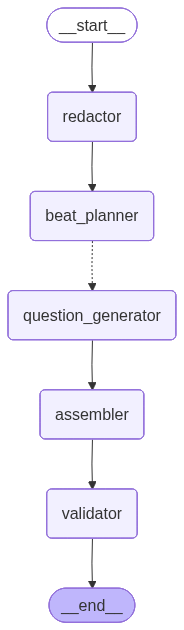

In [156]:

def create_graph():
    builder = StateGraph(PipelineState)

    builder.add_node("redactor", make_redactor_node())
    builder.add_node("beat_planner", beat_planner_node)
    builder.add_node("question_generator", question_generator_worker)
    builder.add_node("assembler", assembler_node)
    builder.add_node("validator", validator_node)

    builder.add_edge(START, "redactor")
    builder.add_edge("redactor", "beat_planner")

    builder.add_edge("question_generator", "assembler")
    builder.add_edge("assembler", "validator")
    builder.add_edge("validator", END)

    graph = builder.compile()
    return graph

graph = create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [157]:
def run_pipeline(user_input: UserInput) -> dict[Beat, list[QuestionObject]]:
    """
    Exapmle of an user input:
    exp1 = {
    "scholarship_name": "Vector scholarships",
    "program_type": "Community Leadership",
    "goal_one_liner": "Machine Learning Workshop hosts for academic engagement.",
    "resume_points": [
        "Led a team of 5 in developing a 3D CNN to decode emotional state from 7tfMRI brain images, improved the test accuracy to 80%."
        "Organized and hosted weekly study paper reading groups for over 15 students in transformers.",
        "Conducted research under Prof Geoffery Hinton, resulting in a published paper in a Neurlps 2025 conference.",
        ],
    }

    THEN write
    user_input = UserInput.model_validate(exp1)
    """

    try:
        graph = create_graph()
        out = graph.invoke({"user_input": user_input})
        return out
    except Exception as e:
        print(f"Exception occured due to {type(e)} as follows | {e}.")

exp1 = {
    "scholarship_name": "Vector scholarships",
    "program_type": "Graduate",
    "goal_one_liner": "Machine Learning Workshop hosts for academic engagement.",
    "resume_points": [
        "Led a team of 5 in developing a 3D CNN to decode emotional state from 7tfMRI brain images, improved the test accuracy to 80%."
        "Organized and hosted weekly study paper reading groups for over 15 students in transformers.",
        "Conducted research under Prof Geoffery Hinton, resulting in a published paper in a Neurlps 2025 conference.",
    ],
}


exp2 = {
    "scholarship_name": "Foresters Financial community grant",
    "program_type": "Community Grant",
    "goal_one_liner": "Machine Learning Workshop hosts for academic engagement.",
    "resume_points": [
        "Led a team of 5 in developing a 3D CNN to decode emotional state from 7tfMRI brain images, improved the test accuracy to 80%."
        "Organized and hosted weekly study paper reading groups for over 15 students in transformers.",
        "Conducted research under Prof Geoffery Hinton, resulting in a published paper in a Neurlps 2025 conference.",
    ],
}


user_input = UserInput.model_validate(exp2)
out = run_pipeline(user_input)

In [158]:
from pprint import pprint
pprint(out, indent=2)

{ 'attempt_count': 3,
  'audit_log': [ { 'agent': 'beat_planner',
                   'data': { 'beats': ['A', 'B', 'C', 'D', 'E'],
                             'missing_counts': { 'A': 3,
                                                 'B': 3,
                                                 'C': 3,
                                                 'D': 3,
                                                 'E': 3}},
                   'event': 'created_beat_plan',
                   'ts_ms': 1768687239904},
                 { 'agent': 'question_generator',
                   'data': { 'beat': 'A',
                             'latency_ms': 2004.36,
                             'n_questions': 2},
                   'event': 'success',
                   'ts_ms': 1768687241910},
                 { 'agent': 'question_generator',
                   'data': { 'beat': 'B',
                             'latency_ms': 2299.87,
                             'n_questions': 2},
                   'ev

In [159]:
from typing import Union
def format_response(state: Union[dict, BaseModel]) -> dict:
    # Convert Pydantic model state to dict if needed

    if hasattr(state, 'model_dump'):
        # Pydantic model - convert to dict
        state_dict = state.model_dump()
    else:
        # Already a dict
        state_dict = state
    
    # walks through any structure and cleans it (converst into dict)
    def to_dict(obj):
        if hasattr(obj, 'model_dump'):
            # Pydantic model - convert to dict
            return obj.model_dump()
        elif isinstance(obj, dict):
            # Dict - recursively convert values
            return {k: to_dict(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            # List - recursively convert items
            return [to_dict(item) for item in obj]
        else:
            # Primitive type - return as-is
            return obj
    
    # Format response structure
    formatted = {
        # Final output (what frontend displays)
        "final_questions_by_beat": to_dict(
            state_dict.get("final_questions_by_beat", {})
        ),
        
        # Redactor Agent output (for PII highlights panel)
        "pii_spans": to_dict(state_dict.get("pii_spans", [])),
        "redacted_input": state_dict.get("redacted_input", ""),
        "canonical_input": state_dict.get("canonical_input", ""),
        
        # Beat Planner Agent output (for beat plan panel)
        "beat_plan": to_dict(state_dict.get("beat_plan", [])),
        
        # Question Generator outputs (intermediate, before assembly)
        "questions_by_beat": to_dict(state_dict.get("questions_by_beat", {})),
        
        # Validator Agent output (for validation panel)
        "validation_report": to_dict(state_dict.get("validation_report")),
        
        # Audit timeline (for progress panel)
        "audit_timeline": state_dict.get("audit_timeline", []),
        
        # Metadata
        "fallback_used": state_dict.get("fallback_used", False),
    }
    
    return formatted


In [ ]:
question_lists = format_response(out).get("final_questions_by_beat").values()
for question_list in question_lists:
    for qo in question_list:
        print(qo.get("question"))

How does your experience with 3D CNNs and brain imaging align with the community focus of the Foresters Financial grant?
What motivated you to apply for this grant, and how does it support your academic engagement goals?
How did your leadership in the 3D CNN project contribute to the 80% test accuracy improvement?
What specific contribution did your published paper make to the 2025 conference?
How will the Machine Learning Workshop foster long-term academic collaboration?
What specific strategies will you use to amplify community engagement through this grant?
How did you foster collaboration within the 3D CNN team to achieve the accuracy improvement?
What challenges did you face while leading the 3D CNN team, and how did you overcome them?
How have your past research experiences, such as leading a team in developing a 3D CNN, shaped your approach to academic engagement?
What specific lessons did you learn from organizing study paper reading groups that you plan to apply to hosting Mac

In [ ]:
format_response(out).get("validation_report").get("errors")

['C: ["Ungrounded entities not found in source: [\'the Machine Learning Workshop\']"]',
 'E: ["Ungrounded entities not found in source: [\'Machine Learning Workshops\']"]']

['C: ["Ungrounded entities not found in source: [\'the Machine Learning Workshop\']"]',
 'E: ["Ungrounded entities not found in source: [\'Machine Learning Workshops\']"]']

In [162]:
out.get("redacted_input")

'Scholarship: Foresters Financial community grant\nProgram type: Community Grant\nGoal: Machine Learning Workshop hosts for academic engagement.\nResume points:\n- Led a team of 5 in developing a 3D CNN to decode emotional state from 7tfMRI brain images, improved the test accuracy to 80%.Organized and hosted weekly study paper reading groups for over 15 students in transformers.\n- Conducted research under Prof <NAME>, resulting in a published paper in a <LOCATION> 2025 conference.\n'